
# ENA Data Browse Images

This notebook is for playing around with plots and images for the ENA Data Browser. I will use this notebook to figure out what kind of plots I want to show and how I want to show them. 

## Types of Plots

This is a preliminary list of things that would be useful to see in a daily view of the ENA site.

* Composite windrose of speed and direction for the day
* Timeseries of precipitation
* RADAR/LIDAR timeseries
* Skew-T charts of available soundings
* Timeseries of CCN at different supersaturation levels
* Synoptic maps from ECMWF with wind and slp (maybe upper level, say 500mb?)
* Satellite imagery

In [70]:
import matplotlib
matplotlib.rcParams['figure.subplot.left'] = 0.1
matplotlib.rcParams['figure.subplot.right'] = 0.9
matplotlib.rcParams['figure.subplot.top'] = 0.95
matplotlib.rcParams['figure.subplot.bottom'] = 0.02

In [71]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

#import matplotlib.pyplot as plt
#import matplotlib.cm as cm
import toolbox as tbx
#%matplotlib inline
import datetime
import numpy as np
import pandas as pd
import glob
import os

from netCDF4 import Dataset, num2date
from mpl_toolkits.basemap import Basemap

# import seaborn as sns
# colors = sns.color_palette()
# sns.palplot(colors)

import matplotlib.pyplot as plt
import matplotlib.cm as cm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [72]:
sample_date = datetime.datetime(2014, 5, 31)
date = sample_date.strftime('%Y-%m-%d')
print(date)

2014-05-31


## Data Sources
Define sources for the different datastreams

In [73]:
# set the base directory
base_directory = os.path.abspath('/Volumes/data/ENA/')
if not os.path.isdir(base_directory):
    base_directory = os.path.abspath('/Volumes/NiftyDrive/Research/data/ENA/')

support_directory = os.path.join(os.getenv("HOME"), 'Documents/htdocs/ena_data_browser/support-files')
plot_directory = os.path.join(os.getenv("HOME"), 'Documents/htdocs/ena_data_browser/support-files/figures')

# Surface Meteorology
sfcmet = tbx.fileIO.NetCDFFolder(os.path.join(base_directory, 'met'))
sfcmet.summary()

# CCN
ccndat = tbx.fileIO.NetCDFFolder(os.path.join(base_directory, 'ccn'))
ccndat.summary()

#UHSAS
uhsas = tbx.fileIO.NetCDFFolder(os.path.join(base_directory, 'uhsas/aos'))
uhsas.summary()

#CN Data
cn = tbx.fileIO.NetCDFFolder(os.path.join(base_directory, 'cn'))
cn.summary()

/Volumes/NiftyDrive/Research/data/ENA/met
Found 697 files total
 > Found 697 items for datastream enametC1

/Volumes/NiftyDrive/Research/data/ENA/ccn
Found 642 files total
 > Found 642 items for datastream enaaosccn100C1

/Volumes/NiftyDrive/Research/data/ENA/uhsas/aos
Found 543 files total
 > Found 543 items for datastream enaaosuhsasC1

/Volumes/NiftyDrive/Research/data/ENA/cn
Found 483 files total
 > Found 483 items for datastream enaaoscpcfC1



In [74]:
print(sfcmet.filelist[-1])
print(ccndat.filelist[-1])
print(uhsas.filelist[-1])
print(cn.filelist[-1])

/Volumes/NiftyDrive/Research/data/ENA/met/enametC1.b1.20150817.000000.cdf
/Volumes/NiftyDrive/Research/data/ENA/ccn/enaaosccn100C1.a1.20150817.000000.nc
/Volumes/NiftyDrive/Research/data/ENA/uhsas/aos/enaaosuhsasC1.a1.20150810.000000.cdf
/Volumes/NiftyDrive/Research/data/ENA/cn/enaaoscpcfC1.a1.20150818.000000.nc


In [75]:
# start with the surface meteorology stuff, using our sample datetime.
for f in sfcmet.filelist:
    if date.replace('-', '') in f:
        break
    else:
        f = None

for c in ccndat.filelist:
    if date.replace('-', '') in c:
        break
    else:
        c = None

for u in uhsas.filelist:
    if date.replace('-', '') in u:
        break
    else:
        u = None

for n in cn.filelist:
    if date.replace('-', '') in n:
        break
    else:
        n = None

In [76]:
print(f)
print(c)
print(u)
print(n)

SFC = tbx.fileIO.NetCDFFile(f)
CCN = tbx.fileIO.NetCDFFile(c)
#UHSAS = tbx.fileIO.UHSAS(u)
CN = tbx.fileIO.NetCDFFile(n)

/Volumes/NiftyDrive/Research/data/ENA/met/enametC1.b1.20140531.000000.cdf
/Volumes/NiftyDrive/Research/data/ENA/ccn/enaaosccn100C1.a1.20140531.000000.cdf
/Volumes/NiftyDrive/Research/data/ENA/uhsas/aos/enaaosuhsasC1.a1.20140531.000006.cdf
/Volumes/NiftyDrive/Research/data/ENA/cn/enaaoscpcfC1.a1.20140531.000000.cdf


In [77]:
SFCDAT = SFC.get_vars(varlist=['atmos_pressure', 
                               'wspd_vec_mean', 
                               'wdir_vec_mean', 
                               'org_precip_rate_mean',
                               'temp_mean'], 
                       exclude='qc').astype(np.float)

In [78]:
CCNDAT = CCN.get_vars(varlist=['N_CCN', 'ss', 'supersat'], 
                            exclude='qc',
                            mapping={'N_CCN': 'CCN', 
                                     'CCN_supersaturation_set_point': 'SS',
                                     'CCN_ss_set': 'SS'})
#print(set(CCNDAT['CCN_supersaturation_set_point']))

/Users/jstemm/Research/toolbox/toolbox/fileIO/netCDF.py:260: VariableWarning: Warning: supersat not found in varlist
  if isinstance(varlist, str):


In [79]:
# CN = cn.process(varlist='concentration')
CNDAT = CN.get_vars('concentration')
CNDAT.concentration.any()

True

In [80]:
# fig, ax = plt.subplots(figsize=(12, 5))
# CN1d = CN.resample('1D', how='mean')
# ax.plot(CN1d.index, CN1d.concentration)

In [81]:
CCN01 = CCNDAT[CCNDAT.SS == 0.1]['CCN'].resample('1Min', how='mean').astype(np.float)
CCN05 = CCNDAT[CCNDAT.SS == 0.8]['CCN'].resample('1Min', how='mean').astype(np.float)

In [82]:
CCN01.name = "CCN01"
CCN05.name = "CCN05"

DATA = SFCDAT.join([CCN01, CCN05])
DATA.fillna(np.float('nan'), inplace=True)

In [83]:
DATA.dtypes

atmos_pressure          float64
org_precip_rate_mean    float64
temp_mean               float64
wdir_vec_mean           float64
wspd_vec_mean           float64
CCN01                   float64
CCN05                   float64
dtype: object

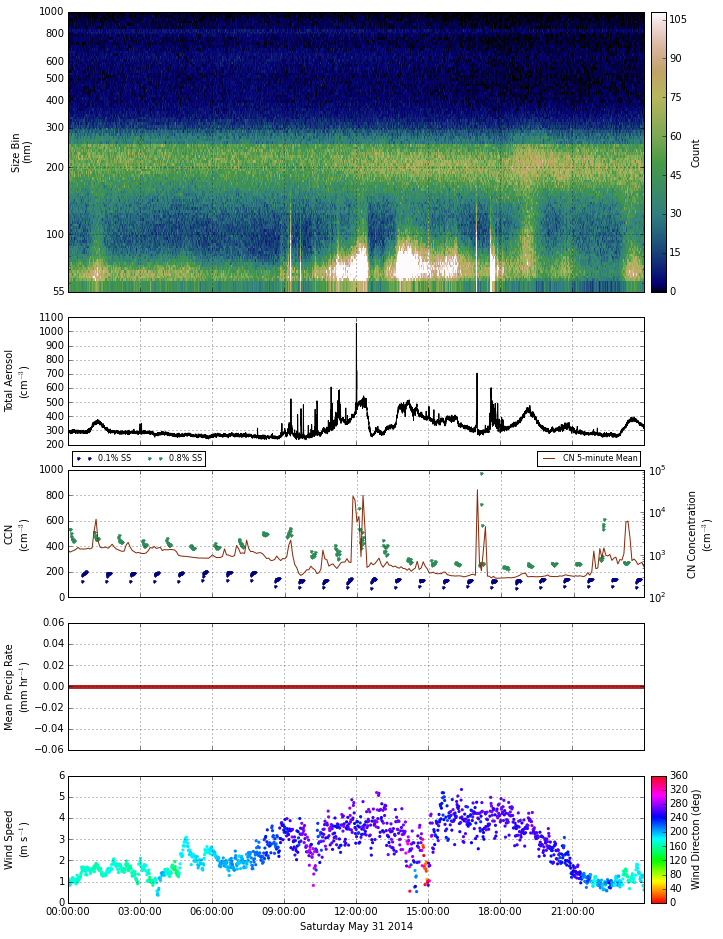

In [84]:
#fig, axes = plt.subplots(4, figsize=(12, 10), sharex=True)

fig = plt.figure(figsize=(10, 15))
n = 6
ycoords = (-0.06, 0.5)

ax = plt.subplot2grid((n, 1), (0,0), rowspan=2)
llim = UHSAS.lower_size_limit[0]

image = ax.pcolormesh(UHSAS.datetimes,
                      np.array(UHSAS.lower_size_limit.tolist()+[UHSAS.upper_size_limit[-1]]),
                              UHSAS.size_distribution.T,
                              vmin=0,
                              vmax=np.nanpercentile(UHSAS.size_distribution, 99),
                              cmap=cm.gist_earth)
ax.set_ylim(bottom=llim)
#ax.set_yticks([UHSAS.lower_size_limit[0]] + ax.get_yticks()[1:].tolist())
ax.grid('on')
ax.set_xticklabels('')
ax.set_ylabel('Size Bin\n(nm)')
ax.set_yscale('log')
ax.set_yticks((llim, 100, 200, 300, 400, 500, 600, 800, 1000))
ax.set_yticklabels([str(int(i)) for i in ax.get_yticks()])
ax.get_yaxis().set_label_coords(*ycoords)
p = ax.get_position()

rect = p.corners()[2].tolist() + [.02] + [p.height]
rect[0] = rect[0] + .01
cax = fig.add_axes(rect)
clb = fig.colorbar(image, cax=cax)
clb.set_label('Count')

l = 2

ax = plt.subplot2grid((n, 1), (l,0))
ax.plot(UHSAS.datetimes, UHSAS.total_concentration, 'k')
ax.set_ylabel("Total Aerosol\n(cm$^{-3}$)")
ax.get_yaxis().set_label_coords(*ycoords)
ax.grid('on')
ax.set_xticklabels('')
l+=1

ax = plt.subplot2grid((n, 1), (l,0))
ccn01 = ax.plot(DATA.index, DATA.CCN01, '.', color='navy', label="0.1% SS", zorder=1)
ccn05 = ax.plot(DATA.index, DATA.CCN05, '.', color='seagreen', label="0.8% SS", zorder=2)
ax.set_ylabel("CCN\n(cm$^{-3}$)")
ax.get_yaxis().set_label_coords(*ycoords)
ll = ax.legend(loc='lower left', bbox_to_anchor=[0, 1], 
         numpoints=2, fontsize=8, ncol=2)
ax.grid('on')
ax.set_xticklabels('')

bx = ax.twinx()
CNPLOT = CNDAT.resample('5Min', how='mean')
cnplt = bx.plot(CNPLOT.index, CNPLOT.concentration, '-', color='#8A2908', zorder=-10, label='CN 5-minute Mean')
bx.get_yaxis().set_label_coords(1.08, 0.5)
#bx.set_ylim(top=np.percentile(CNPLOT.concentration, 99.))
bx.set_ylabel('CN Concentration\n(cm$^{-3}$)')
bx.set_yscale('log')
ll = bx.legend(loc='lower right', bbox_to_anchor=[1, 1],
               numpoints=2, fontsize=8, ncol=2)

# lns = ccn01+ccn05+cnplt
# labs = [lab.get_label() for lab in lns]
# ll = ax.legend(lns, labs, loc='lower right', bbox_to_anchor=[1, 1], 
#          numpoints=2, fontsize=8, ncol=3)

l+=1

ax = plt.subplot2grid((n, 1), (l,0))
ax.plot(DATA.index, DATA.org_precip_rate_mean, '.', color='firebrick')
ax.set_ylabel("Mean Precip Rate\n(mm hr$^{-1}$)")
ax.get_yaxis().set_label_coords(*ycoords)
ax.grid('on')
ax.set_xticklabels('')
l+=1

ax = plt.subplot2grid((n, 1), (l, 0))
sc = ax.scatter(DATA.index, DATA.wspd_vec_mean, 
           c=DATA.wdir_vec_mean, cmap=cm.hsv,
           edgecolor='none',
           s=10,
           vmin=0, vmax=360)
ax.set_ylabel('Wind Speed\n(m s$^{-1}$)')
ax.get_yaxis().set_label_coords(*ycoords)
ax.grid('on')
ax.set_xlim(DATA.index[0], DATA.index[-1])
ax.set_ylim(bottom=0)
p = ax.get_position()

rect = p.corners()[2].tolist() + [.02] + [p.height]
rect[0] = rect[0] + .01
cax = fig.add_axes(rect)
clb = fig.colorbar(sc, cax=cax)
clb.set_label('Wind Directon (deg)')

l+=1

ax.set_xlabel(sample_date.strftime('%A %B %d %Y'))

figout = os.path.join(plot_directory, 'main/')
if not os.path.isdir(figout):
    os.makedirs(figout)

#fig.savefig(os.path.join(figout, date+'.png'), transparent=False)

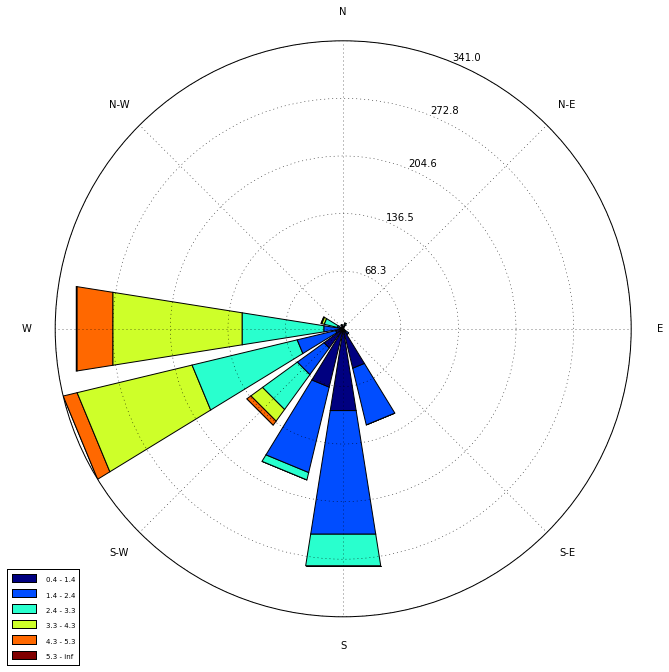

In [85]:
fig, ax = tbx.plotting.windrose(direction=DATA['wdir_vec_mean'], 
                                speed=DATA['wspd_vec_mean'],
                                #bins=[0, 4, 6, 7, 8])
                                #colors=sns.color_palette("hls", 6))
                                )

figout = os.path.join(plot_directory, 'rose/')
if not os.path.isdir(figout):
    os.makedirs(figout)
    
#fig.savefig(os.path.join(figout, date+'.png'))

http://lance-modis.eosdis.nasa.gov/imagery/subsets/?subset=ARM_Azores.2014151.aqua.2km.jpg


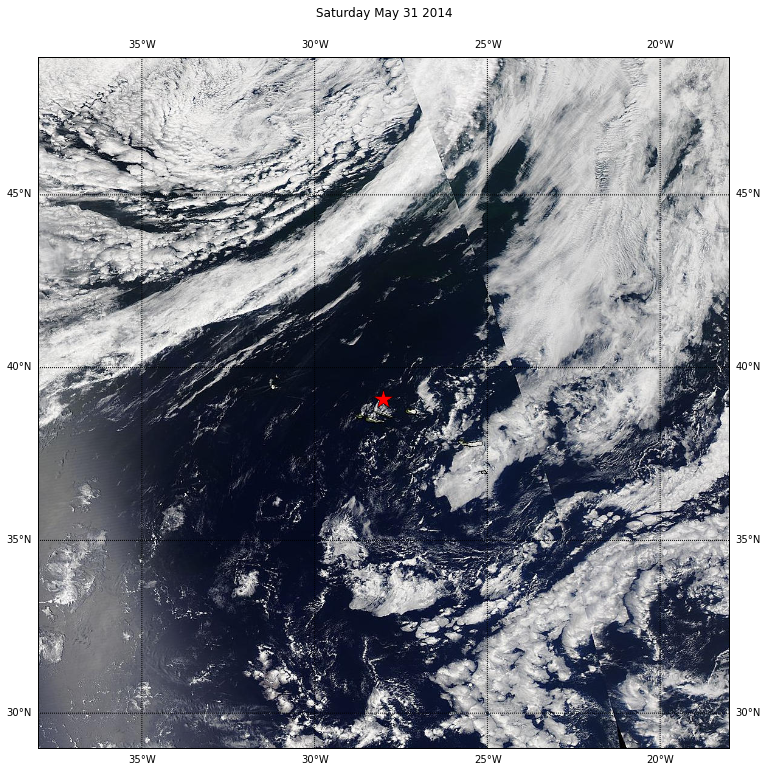

In [86]:
imgsrc = 'http://lance-modis.eosdis.nasa.gov/imagery/subsets/?subset=ARM_Azores.' \
            + sample_date.strftime('%Y%j') \
            + '.aqua.2km.jpg'

#ENA - Graciosa Island, Azores
#39° 5' 29.68" N, 28° 1' 32.34" W 
#Altitude: 30.48 meters

from PIL import Image
import urllib, cStringIO
#from shapelib import ShapeFile

file = cStringIO.StringIO(urllib.urlopen(imgsrc).read())
try:
    img = Image.open(file)
except IOError:
    img = None

print(imgsrc)
fig, ax = plt.subplots(figsize=(12,12))
ax.set_title(sample_date.strftime('%A %B %d %Y'), y=1.05)
m = Basemap(llcrnrlat=28.9951, llcrnrlon=-38.0039,
            urcrnrlat=48.9990, urcrnrlon=-18.000,
            resolution='c', ax=ax, area_thresh=0.1)

#m.drawcoastlines()
m.drawparallels(np.arange(-90, 90, 5), labels=[1,1,1,1])
m.drawmeridians(np.arange(-180, 180, 5), labels=[1,1,1,1])
if img is not None:
    m.imshow(img, origin='upper')

m.plot(-28.02565, 39.091578, 'r*', markersize=20, latlon=True)

m.readshapefile(os.path.join(support_directory, 'PRT_adm/PRT_adm0'), 'prt', drawbounds=True)

if img is not None:
    img.close()

In [87]:
# fig.savefig(plot_directory+'map.png', transparent=False)